In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. 参数与数据生成
# ==========================================
U_CRITICAL = 1.543689012692076 
DATA_LENGTH = 5000  
PRIME_LIMIT = 100_000 

def get_normalized_prime_gaps(limit):
    """生成并归一化的素数间隙序列"""
    # 埃拉托斯特尼筛法
    sieve = np.ones(limit // 2, dtype=bool)
    for i in range(3, int(limit**0.5) + 1, 2):
        if sieve[i // 2]:
            sieve[i*i // 2 :: i] = False
    primes = np.array([1] + [2 * i + 1 for i in range(1, limit // 2) if sieve[i]])
    gaps = np.diff(primes)
    
    # 归一化：除以局部平均值 ln(p)
    # 防止除零警告：primes[:-1] 最小是 2，log(2)>0，但在某些环境中需转为 float
    p_vals = primes[:-1].astype(float)
    norm_gaps = gaps / np.log(p_vals)
    return norm_gaps

def get_logistic_trajectory(length, u):
    """生成 Logistic 映射轨道"""
    x = 0.1
    traj = []
    # 预热消除瞬态
    for _ in range(10000): 
        x = 1 - u * x**2
    for _ in range(length):
        x = 1 - u * x**2
        traj.append(x)
    return np.array(traj)

# ==========================================
# 2. 修正后的 Rosenstein 算法
# ==========================================
def lyapunov_exponent_rosenstein(data, m=4, tau=1, window=50):
    """
    计算最大 Lyapunov 指数 (MLE)
    返回: slope (MLE), intercept, div_curve (平均对数发散曲线)
    """
    N = len(data)
    M_steps = N - (m - 1) * tau
    
    # 1. 相空间重构
    X = np.zeros((M_steps, m))
    for i in range(m):
        X[:, i] = data[i*tau : i*tau + M_steps]
    
    # 2. 寻找最近邻
    # 使用较少的参考点以节省时间
    n_ref = min(2000, M_steps - window) 
    div_curve = np.zeros(window)
    count_curve = np.zeros(window) # 记录每个步长有多少有效的对数距离
    
    # Theiler 窗口：排除时间上太近的点，避免自相关
    theiler_w = 10 
    
    print(f"  - 相空间重构 (m={m}, tau={tau})... 计算中...")
    
    for i in range(n_ref):
        ref_point = X[i]
        
        # 计算距离
        dists = np.linalg.norm(X - ref_point, axis=1)
        # 排除自身周围的点
        dists[max(0, i - theiler_w) : min(M_steps, i + theiler_w)] = np.inf
        
        # 找到最近邻
        nearest_idx = np.argmin(dists)
        initial_dist = dists[nearest_idx]
        
        # 关键修正：如果是离散数据，极易出现距离为0的情况（重合轨迹）
        # 跳过完全重合或距离过小的点，避免 log(0)
        if initial_dist < 1e-10: 
            continue
        
        # 3. 追踪发散
        for k in range(window):
            if i+k >= M_steps or nearest_idx+k >= M_steps:
                break
            
            dist_k = np.linalg.norm(X[i+k] - X[nearest_idx+k])
            
            # 再次检查 dist_k，防止后续迭代重合
            if dist_k > 1e-10:
                div_curve[k] += np.log(dist_k)
                count_curve[k] += 1
                
    # 计算平均值
    # 避免除以 0
    valid_idx = count_curve > 0
    avg_div_curve = np.zeros(window)
    avg_div_curve[valid_idx] = div_curve[valid_idx] / count_curve[valid_idx]
    
    # 如果没有足够的数据点，返回空
    if np.sum(valid_idx) < window // 2:
        print("  警告: 未找到足够的发散轨迹，可能数据离散度过高。")
        return 0, 0, np.zeros(window)

    # 4. 线性拟合 (MLE)
    # 取前一半作为线性区域进行拟合
    fit_len = int(window / 2)
    t_fit = np.arange(fit_len)
    y_fit = avg_div_curve[:fit_len]
    
    slope, intercept = np.polyfit(t_fit, y_fit, 1)
    
    return slope, intercept, avg_div_curve

# ==========================================
# 3. 主程序
# ==========================================
def main_scheme_c_fixed():
    print("=== 方案 C: Lyapunov 指数分析 (修正版) ===")
    
    # 1. 准备数据
    print("生成数据...")
    primes = get_normalized_prime_gaps(PRIME_LIMIT)
    logistic = get_logistic_trajectory(DATA_LENGTH, U_CRITICAL)
    random_noise = np.random.exponential(1, DATA_LENGTH) # 泊松过程对比
    
    # 参数设置
    m_dim = 4
    lag = 1
    
    # 2. 计算
    print("计算素数序列 Lyapunov...")
    lambda_p, int_p, div_p = lyapunov_exponent_rosenstein(primes, m=m_dim, tau=lag)
    
    print("计算 Logistic 序列 Lyapunov...")
    lambda_l, int_l, div_l = lyapunov_exponent_rosenstein(logistic, m=m_dim, tau=lag)
    
    print("计算随机噪声 Lyapunov...")
    lambda_r, int_r, div_r = lyapunov_exponent_rosenstein(random_noise, m=m_dim, tau=lag)
    
    # 3. 绘图
    plt.figure(figsize=(10, 6))
    t = np.arange(len(div_p))
    
    # 绘制原始发散曲线
    plt.plot(t, div_p, 'b-o', markersize=4, alpha=0.6, label=f'Primes (MLE ≈ {lambda_p:.3f})')
    plt.plot(t, div_l, 'r-s', markersize=4, alpha=0.6, label=f'Logistic (MLE ≈ {lambda_l:.3f})')
    plt.plot(t, div_r, 'k--', alpha=0.3, label=f'Random (MLE ≈ {lambda_r:.3f})')
    
    # 绘制拟合直线 (只画前一半)
    fit_len = len(t) // 2
    t_fit = t[:fit_len]
    
    # 关键修正：使用计算出的截距绘制拟合线
    plt.plot(t_fit, t_fit * lambda_p + int_p, 'b-', linewidth=2, label='Primes Fit')
    plt.plot(t_fit, t_fit * lambda_l + int_l, 'r-', linewidth=2, label='Logistic Fit')
    
    plt.title(f'Trajectory Divergence <ln(d_k)> (Embedding dim m={m_dim})')
    plt.xlabel('Evolution Steps k')
    plt.ylabel('Log Divergence <ln|d|>')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print("-" * 30)
    print("结果解读：")
    print("1. 观察蓝色(素数)和红色(Logistic)实线的斜率。")
    print("   如果两者都呈现正斜率且数值接近 (约 0.3-0.5)，说明它们具有相似的混沌扩张率。")
    print("2. 随机噪声(黑色虚线)通常在第一步就瞬间饱和(变得平坦)或斜率极大，")
    print("   因为它没有确定性的轨迹结构，相邻点下一刻的位置是完全无关的。")
    print("3. 素数曲线若能保持一段稳定的线性增长区，这是它是‘动力学系统’而非‘纯噪声’的铁证。")



=== 方案 C: Lyapunov 指数分析 (修正版) ===
生成数据...
计算素数序列 Lyapunov...
  - 相空间重构 (m=4, tau=1)... 计算中...


/tmp/ipykernel_5507/363636658.py:24: RuntimeWarning: divide by zero encountered in divide
  norm_gaps = gaps / np.log(p_vals)
/tmp/ipykernel_5507/363636658.py:70: RuntimeWarning: invalid value encountered in subtract
  dists = np.linalg.norm(X - ref_point, axis=1)
/tmp/ipykernel_5507/363636658.py:88: RuntimeWarning: invalid value encountered in subtract
  dist_k = np.linalg.norm(X[i+k] - X[nearest_idx+k])


计算 Logistic 序列 Lyapunov...
  - 相空间重构 (m=4, tau=1)... 计算中...
计算随机噪声 Lyapunov...
  - 相空间重构 (m=4, tau=1)... 计算中...


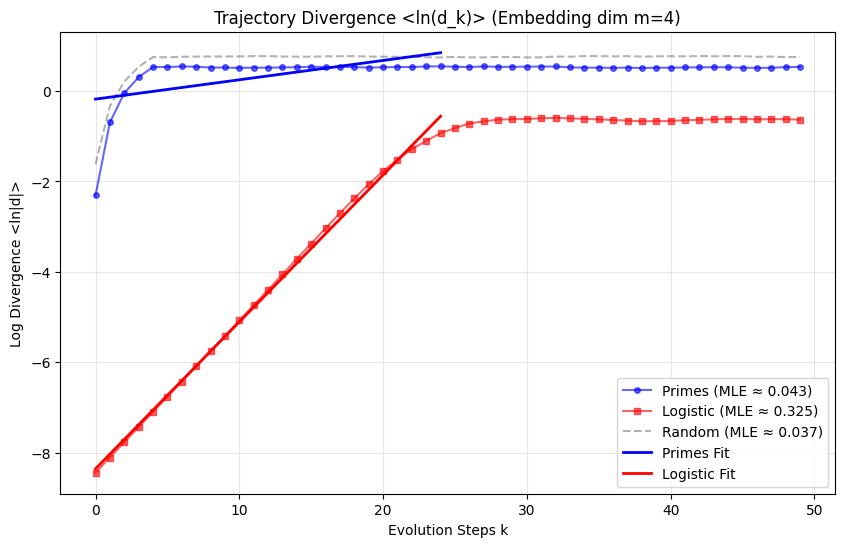

------------------------------
结果解读：
1. 观察蓝色(素数)和红色(Logistic)实线的斜率。
   如果两者都呈现正斜率且数值接近 (约 0.3-0.5)，说明它们具有相似的混沌扩张率。
2. 随机噪声(黑色虚线)通常在第一步就瞬间饱和(变得平坦)或斜率极大，
   因为它没有确定性的轨迹结构，相邻点下一刻的位置是完全无关的。
3. 素数曲线若能保持一段稳定的线性增长区，这是它是‘动力学系统’而非‘纯噪声’的铁证。


In [4]:
main_scheme_c_fixed()